In [1]:
import pandas as pd
import pickle
import numpy as np
import plotly.express as px
from GO_similarity import parse_background_probs, sim_go_families, sim_go_term_family
from goatools.obo_parser import GODag
import matplotlib.pyplot as plt
import re
import gseapy as gp


<Axes: >

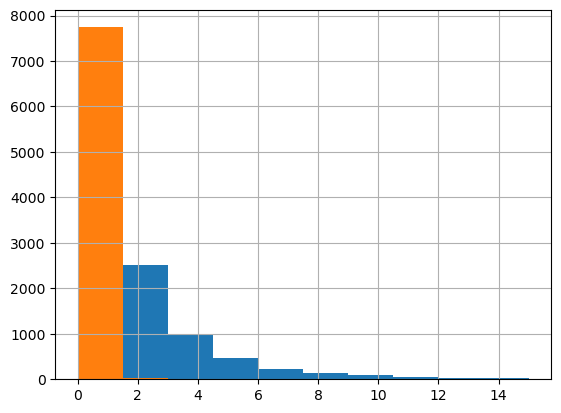

In [2]:
cnts = pd.read_csv('/home/victor/bioinfo1/BioinformaticsAndPractice1/counts_and_GO.csv', comment='#')
cnts.dropna(axis=0, inplace=True)
cnts = cnts[(cnts['RNA-control.bam'] >= 30)& (cnts['CLIP-35L33G.bam'] >= 30) & (cnts['RNA-siLin28a.bam'] >= 30) & (cnts['RNA-siLuc.bam'] >= 30)&(cnts['RPF-siLuc.bam'] >= 80)].copy()
cnts.set_index("Geneid", inplace=True, drop=True)
cnts['clip_enrichment'].hist(range=[0,15])
cnts['ribosome_density_change'].hist(range=[0,15])

In [3]:
clip_cut = cnts["clip_enrichment"].quantile(0.90)          # top 10 %
dte_cut  = cnts["ribosome_density_change"].abs().quantile(0.90)
enriched = cnts[
    (cnts["clip_enrichment"] >= clip_cut) &
    (cnts["ribosome_density_change"].abs() >= dte_cut)
].copy()
print(len(enriched))

324


In [4]:
print(len(enriched))
enriched.head()


324


,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,clip_enrichment,ribosome_density_change,gene_symbol,GO_list,GO
Geneid,,,,,,,,,,,,,,,,
ENSMUSG00000051285,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,7159144;7159154;7159328;7159390;7190418;721786...,7159440;7159440;7159440;7159440;7190839;721796...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,6654,3508,529,2360,1775,208,138,6.631380,1.133628,Pcmtd1,"['GO:0004719', 'GO:1990756', 'GO:0008168', 'GO...",GO:0004719;GO:1990756;GO:0008168;GO:0031466;GO...
ENSMUSG00000025931,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,20960830;20988064;20988098;20992483;20992483;2...,20960910;20988113;20988113;20992590;20992590;2...,+;+;+;+;+;+;+;+;+;+;+;+;+,5488,405,71,283,141,302,143,5.704225,1.052213,Paqr8,"['GO:0048477', 'GO:0005496', 'GO:0016020', 'GO...",GO:0048477;GO:0005496;GO:0016020;GO:0005886;GO...
ENSMUSG00000073725,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,24717711;24717741;24717820;24718007;24724478;2...,24717897;24717897;24717897;24718115;24724654;2...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,5960,562,102,264,225,801,498,5.509804,1.370824,Lmbrd1,"['GO:0072583', 'GO:0005515', 'GO:0035612', 'GO...",GO:0072583;GO:0005515;GO:0035612;GO:0031419;GO...
ENSMUSG00000037470,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,36179108;36182563;36182567;36185113;36185113;3...,36183332;36183332;36183332;36185266;36185266;3...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,12853,9763,1574,5584,3732,11416,7892,6.202668,0.966770,Uggt1,"['GO:0005783', 'GO:0006486', 'GO:0005793', 'GO...",GO:0005783;GO:0006486;GO:0005793;GO:0032991;GO...
ENSMUSG00000048234,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,39590377;39591550;39594559;39594559;39594686;3...,39591596;39591596;39594751;39594751;39594751;3...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-,2838,2319,303,717,629,515,454,7.653465,0.995137,Rnf149,"['GO:0008270', 'GO:0031647', 'GO:0043409', 'GO...",GO:0008270;GO:0031647;GO:0043409;GO:0061630;GO...


In [5]:
enriched_ids = enriched.index.to_series().tolist() 
enriched_ids[:5]

['ENSMUSG00000051285',
 'ENSMUSG00000025931',
 'ENSMUSG00000073725',
 'ENSMUSG00000037470',
 'ENSMUSG00000048234']

In [6]:
def batched(iterable, n): 
    items = []
    for item in iterable:
        items.append(item)
        if len(items) == n:
            yield items
            items = []
    if items:
        yield items

In [7]:
bm = gp.biomart.Biomart()
results = []

for batch in batched(enriched_ids, 100):
    res = bm.query(dataset='mmusculus_gene_ensembl', 
                   attributes=['ensembl_gene_id', 'external_gene_name'],
                   filters={'ensembl_gene_id': batch})
    results.append(res)

results = pd.concat(results)
results.head()

,ensembl_gene_id,external_gene_name
0,ENSMUSG00000005973,Rcn1
1,ENSMUSG00000006386,Tek
2,ENSMUSG00000007613,Tgfbr1
3,ENSMUSG00000008763,Man1a2
4,ENSMUSG00000009207,Lnpk


In [8]:
enriched_genenames = results['external_gene_name'].dropna().drop_duplicates().tolist() #9
len(enriched_genenames)

324

In [9]:
enr = gp.enrichr(gene_list=enriched_genenames,
                 gene_sets=['KEGG_2019_Mouse'],
                 organism='Mouse',
                 outdir='test/enrichr_kegg',
                 cutoff=0.05)

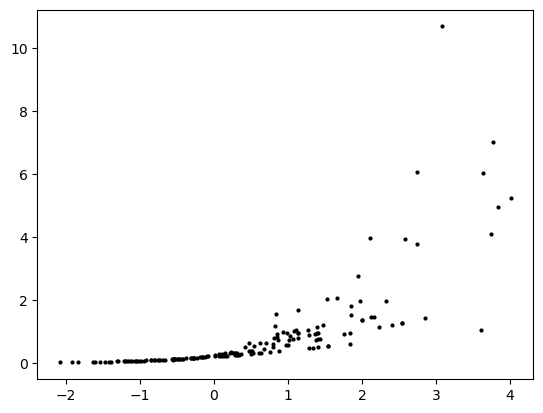

In [10]:
plt.scatter(
    np.log2(enr.res2d['Odds Ratio']),
    -np.log10(enr.res2d['P-value']),
    c='black', s=4)

In [11]:
enr.res2d.sort_values(by='Adjusted P-value').head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Protein processing in endoplasmic reticulum,19/163,2.037902e-11,3.342159e-09,0,0,8.449636,208.000587,EDEM3;MBTPS1;TUSC3;AMFR;SEL1L;SSR3;HSP90B1;HER...
1,KEGG_2019_Mouse,N-Glycan biosynthesis,9/50,9.611125e-08,7.881123e-06,0,0,13.682927,221.085440,FUT8;GANAB;TUSC3;MAN1A2;MAN2A1;MGAT5;ALG5;STT3...
2,KEGG_2019_Mouse,Lysosome,12/124,8.395198e-07,3.830489e-05,0,0,6.718407,93.993436,GALC;CD164;LAPTM4A;ASAH1;GNPTAB;NPC1;SORT1;LAM...
3,KEGG_2019_Mouse,Sphingolipid metabolism,8/48,9.342657e-07,3.830489e-05,0,0,12.427848,172.542091,GALC;UGCG;ASAH1;CERS6;ACER3;DEGS1;SGMS2;B4GALT6
4,KEGG_2019_Mouse,Fatty acid elongation,6/29,5.986113e-06,1.963445e-04,0,0,16.122231,193.887055,ELOVL4;PPT1;ELOVL6;HSD17B12;ELOVL7;HACD3


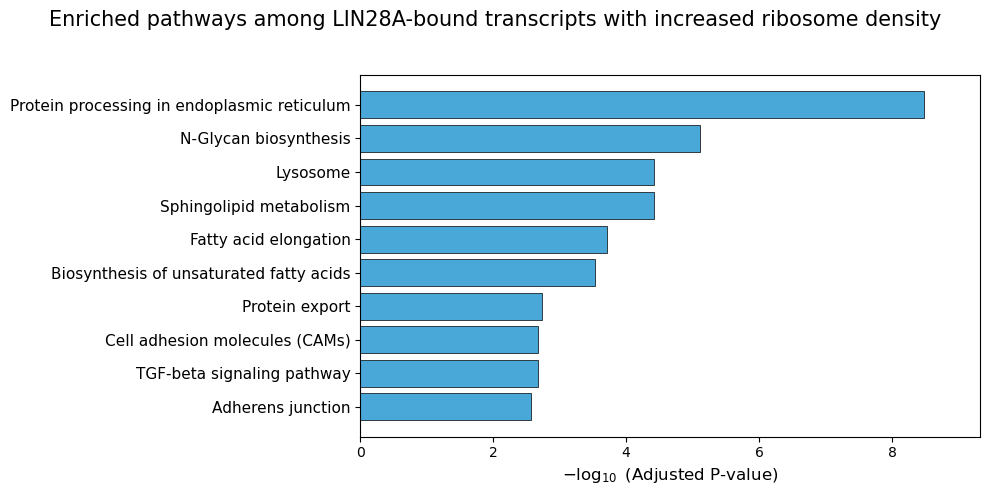

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. choose top-N pathways & transform p-values ----------
plot_df = (enr.res2d
           .sort_values("Adjusted P-value")
           .head(10)                           # top 10 hits
           .copy())
plot_df["minus_log10_FDR"] = -np.log10(plot_df["Adjusted P-value"])
plot_df = plot_df[::-1]                        # largest bar on top

# ---------- 2. build the figure ----------
fig, ax = plt.subplots(figsize=(10, 5))        # wide layout

ax.barh(
    plot_df["Term"],
    plot_df["minus_log10_FDR"],
    color="#4aa8d8",           # sky-blue
    edgecolor="k",
    linewidth=0.5
)

ax.set_xlabel(r"$-\log_{10}$ (Adjusted P-value)", fontsize=12)
ax.set_ylabel("")                               # no y-label
ax.tick_params(axis="y", labelsize=11)
ax.set_xlim(0, plot_df["minus_log10_FDR"].max()*1.1)

# ---------- 3. centred, figure-level title ----------
fig.suptitle(
    "Enriched pathways among LIN28A-bound transcripts with increased ribosome density",
    fontsize=15,
    y=0.98                                     # a bit lower than default
)

plt.tight_layout(rect=[0, 0, 1, 0.95])         # leave space for suptitle
plt.show()


In [13]:
enr = gp.enrichr(gene_list=enriched_genenames,
                 gene_sets=['GO_Biological_Process_2025'],
                 organism='Mouse',
                 outdir='test/enrichr_kegg',
                 cutoff=0.05)

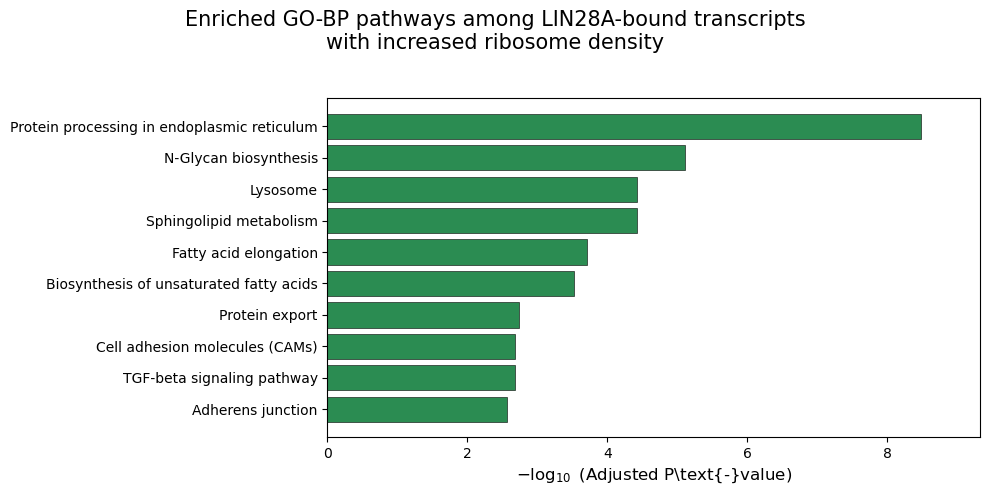

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# plot_df already contains the GO-BP results (Term, minus_log10_FDR)
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(
    plot_df["Term"],
    plot_df["minus_log10_FDR"],
    color="#2b8c52",          # deep green (CIELAB-distant from sky-blue)
    edgecolor="k",
    linewidth=0.4
)

ax.set_xlabel(r"$-\log_{10}$ (Adjusted P\text{-}value)", fontsize=12)
ax.set_xlim(0, plot_df["minus_log10_FDR"].max() * 1.1)

fig.suptitle(
    "Enriched GO-BP pathways among LIN28A-bound transcripts\nwith increased ribosome density",
    fontsize=15,
    y=0.98                    # add a bit of space above bars
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
